## Single Shot Detector for ExtremeWeather Data

### Preprocessing the Data
The [ExtremeWeather](https://extremeweatherdataset.github.io/) data set consists of weather data for a specific 25km region from 1979 to 2005. 
The data is organized by year and contains 4 images per day. Each image has 768x1152 pixels across 16 channels for different weather variables. 
In addition, each day has up to 15 bounding boxes
surrounding extreme weather events classified as Tropical Depression, Tropical Cyclone, Extratropical Cyclone, and Atmospheric River.

The goal is to correctly identify and classify extreme weather events. 
The first challenge is the sheer size of the data set.
Each year, even when compressed, takes 64 GB to store.
As the "small" data set, we consider training on 1979 and 1981 then testing on 1984.
We preprocess each year by considering only the month of July and rescaling each image so its of size 300x300.
In addition, we choose 3 of the 16 channels by hand for 'visual explainability' of bounding boxes.
All together, we are able to reduce the size of the compressed data from 64 GB to 4 MB consisting of 124 300x300 images and bounding boxes.




### Set up

In [1]:
## Set up
### Loading Data
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### Model
import numpy as np
import torch
import gc

### Visualization
from matplotlib import patches
import matplotlib.pyplot as plt

### Prep bounding boxes
import itertools
! pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110
import nvidia.dali as dali

### Store data in drive
from google.colab import drive
drive.mount('/content/drive')

#### Ignore warnings
#import warnings
#warnings.filterwarnings("ignore")



Looking in indexes: https://pypi.org/simple, https://developer.download.nvidia.com/compute/redist
     |███████████████████████████████▏| 834.1 MB 1.3 MB/s eta 0:00:18tcmalloc: large alloc 1147494400 bytes == 0x55dbeaa3c000 @  0x7f1fdf5e9615 0x55dbb22bd4cc 0x55dbb239d47a 0x55dbb22c02ed 0x55dbb23b1e1d 0x55dbb2333e99 0x55dbb232e9ee 0x55dbb22c1bda 0x55dbb2333d00 0x55dbb232e9ee 0x55dbb22c1bda 0x55dbb2330737 0x55dbb23b2c66 0x55dbb232fdaf 0x55dbb23b2c66 0x55dbb232fdaf 0x55dbb23b2c66 0x55dbb232fdaf 0x55dbb22c2039 0x55dbb2305409 0x55dbb22c0c52 0x55dbb2333c25 0x55dbb232e9ee 0x55dbb22c1bda 0x55dbb2330737 0x55dbb232e9ee 0x55dbb22c1bda 0x55dbb232f915 0x55dbb22c1afa 0x55dbb232fc0d 0x55dbb232e9ee
     |████████████████████████████████| 857.7 MB 4.4 kB/s 
Mounted at /content/drive


### Loading the Data

In [2]:
# Modified from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class ExtremeWeatherDataset(Dataset):
  def __init__(self, dir):
    self.bboxes = []
    self.labels = []
    with open(os.path.join(dir, 'bboxes.txt')) as f:
      for line in f:
        self.bboxes += [eval(line)]
    with open(os.path.join(dir, 'labels.txt')) as f:
      for line in f:
        self.labels += [eval(line)]
    self.dir = dir


  def __len__(self):
    return len(self.bboxes)

  def __getitem__(self, idx):
    img_path = os.path.join(self.dir, str(idx)+'.jpg')
    image = read_image(img_path)
    bbox = self.bboxes[idx]
    label = self.labels[idx]
    return [image, bbox, label]

In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))

prefix = '/content/drive/My Drive/extremeweather/' # where the data is stored
train_data = ExtremeWeatherDataset(dir=prefix+'train/')
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate_fn)

### Visualizing Images

In [4]:
EVENTS = ['Tropical Depression', 'Tropical Cyclone', 'Extratropical Cyclone', 'Atmospheric River']
NAMES = ['Sea Level Pressure', 'Total Water', 'Lowest Zonal Wind']
COLORS = ['red', 'blue', 'white', 'black']

def plot_image(image, box, labels):
  if len(image.shape) == 2: image = np.array([image])
  num_channels = image.shape[0]
  num_rows = int(np.sqrt(num_channels))
  num_cols = int(np.round(num_channels//num_rows))
  fig, axs = plt.subplots(num_rows,num_cols, figsize=(15,15)) 
  fig.tight_layout()
  for i in range(num_rows):
    for j in range(num_cols):
      channel = i*num_cols + j 
      if channel < image.shape[0]:
        if num_channels == 1: ax = axs
        elif num_rows == 1: ax = axs[j]
        elif num_rows > 1: ax = axs[i,j]
        ax.axis('off')
        ax.imshow(image[channel,]) 
        addbox(ax, box, labels)
        ax.set_title(NAMES[channel])
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()
    
def addbox(ax, box, labels):
  for i in range(len(box)):
    left, top, right, bottom = box[i]
    handles, existing_labels = ax.get_legend_handles_labels()
    label = "" if (labels == None) or (EVENTS[labels[i]] in existing_labels) else EVENTS[labels[i]]
    ax.add_patch(patches.Rectangle(xy=(left, bottom), width=right-left,
                                    height=top-bottom, fill=False,
                                    label=label, color=COLORS[labels[i]]))



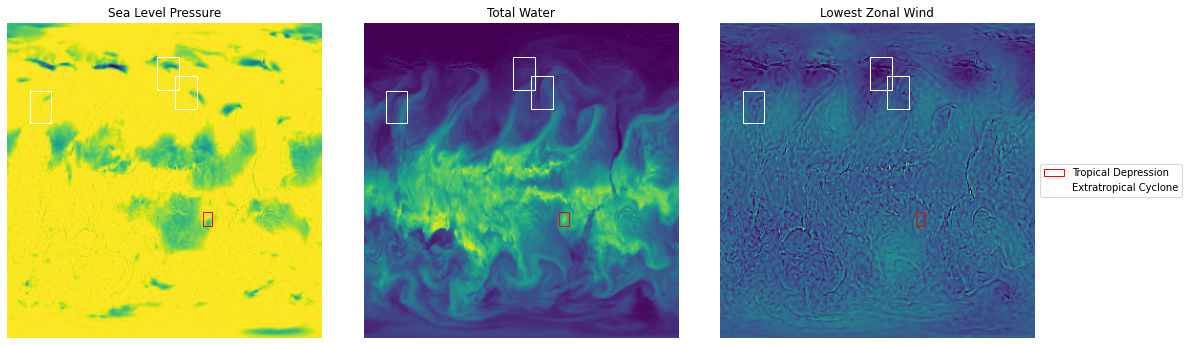

In [5]:
# Plot images
images, bboxes, labels = next(iter(train_dataloader))
plot_image(images[0], bboxes[0], labels[0])

### Training the SSD Model
Instead of building the SSD model from scratch, we use a pretrained model on the COCO database. 

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [37]:
## Object detection on the untrained model
images, bboxes, labels = next(iter(train_dataloader)) #tensor = utils.prepare_tensor(images)
with torch.no_grad():
  detections_batch = ssd_model(images[0]/255) # normalize between 0 and 1
#results_per_input = utils.decode_results(detections_batch)
#best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]
#classes_to_labels = utils.get_coco_object_dictionary()

RuntimeError: ignored

#### Formatting for bounding boxes

In [9]:
# From https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Detection/SSD/ssd/utils.py

class DefaultBoxes(object):
    def __init__(self, fig_size, feat_size, steps, scales, aspect_ratios, \
                       scale_xy=0.1, scale_wh=0.2):

        self.feat_size = feat_size
        self.fig_size = fig_size

        self.scale_xy_ = scale_xy
        self.scale_wh_ = scale_wh

        # According to https://github.com/weiliu89/caffe
        # Calculation method slightly different from paper
        self.steps = steps
        self.scales = scales

        fk = fig_size/np.array(steps)
        self.aspect_ratios = aspect_ratios

        self.default_boxes = []
        # size of feature and number of feature
        for idx, sfeat in enumerate(self.feat_size):

            sk1 = scales[idx]/fig_size
            sk2 = scales[idx+1]/fig_size
            sk3 = np.sqrt(sk1*sk2)
            all_sizes = [(sk1, sk1), (sk3, sk3)]

            for alpha in aspect_ratios[idx]:
                w, h = sk1*np.sqrt(alpha), sk1/np.sqrt(alpha)
                all_sizes.append((w, h))
                all_sizes.append((h, w))
            for w, h in all_sizes:
                for i, j in itertools.product(range(sfeat), repeat=2):
                    cx, cy = (j+0.5)/fk[idx], (i+0.5)/fk[idx]
                    self.default_boxes.append((cx, cy, w, h))

        self.dboxes = torch.tensor(self.default_boxes, dtype=torch.float)
        self.dboxes.clamp_(min=0, max=1)
        # For IoU calculation
        self.dboxes_ltrb = self.dboxes.clone()
        self.dboxes_ltrb[:, 0] = self.dboxes[:, 0] - 0.5 * self.dboxes[:, 2]
        self.dboxes_ltrb[:, 1] = self.dboxes[:, 1] - 0.5 * self.dboxes[:, 3]
        self.dboxes_ltrb[:, 2] = self.dboxes[:, 0] + 0.5 * self.dboxes[:, 2]
        self.dboxes_ltrb[:, 3] = self.dboxes[:, 1] + 0.5 * self.dboxes[:, 3]

    @property
    def scale_xy(self):
        return self.scale_xy_

    @property
    def scale_wh(self):
        return self.scale_wh_

    def __call__(self, order="ltrb"):
        if order == "ltrb": return self.dboxes_ltrb
        if order == "xywh": return self.dboxes


def dboxes300():
    figsize = 300
    feat_size = [38, 19, 10, 5, 3, 1]
    steps = [8, 16, 32, 64, 100, 300]
    # use the scales here: https://github.com/amdegroot/ssd.pytorch/blob/master/data/config.py
    scales = [21, 45, 99, 153, 207, 261, 315]
    aspect_ratios = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]
    dboxes = DefaultBoxes(figsize, feat_size, steps, scales, aspect_ratios)
    return dboxes

In [42]:
dboxes = dboxes300()
anchors = dboxes(order='ltrb').cpu().numpy().flatten().tolist()
box_encoder = dali.ops.BoxEncoder(device="cpu", criteria=0.5, anchors=anchors)

for images, bboxes, labels in train_dataloader:
  for i in range(len(images)):
    bbox_tensor, label_tensor = torch.Tensor(bboxes[i]), torch.Tensor(labels[i])
    gloc, glabel = box_encoder(bbox_tensor, label_tensor)
  ploc, plabel = ssd_model(images[0])


RuntimeError: ignored